In [ ]:
# !rm -rf /content/models/part1
# !rm -rf /content/models/part3
# !rm -rf /content/models/*.txt
# !rm -rf /content/models/*.png
!rm -rf '/content/models2.8-3.6'

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import shuffle
from scipy.interpolate.rbf import Rbf
from scipy.interpolate import griddata

import datetime
import os
import pickle

path='/content/drive/MyDrive/dipoles_new/dipoles-0001_2.8-3.6/'
#path='/content/drive/MyDrive/dipoles-0001_3.2-3.6/'

datetime=str(datetime.datetime.now())
thrs=0.5
num_samples=600
attr='coefMeanM0M1'
num_models=10
freq_range=path.split('_')[2] # 1

path_to_general_models=f'/content/models/'
if not os.path.exists(path_to_general_models):
  os.mkdir(path_to_general_models)

path_to_models=path_to_general_models+f'models{freq_range}/'
#path_to_file='/content/drive/MyDrive/fact_coord.txt'
path_to_file='/content/drive/MyDrive/dipoles_new/LFS_grid_200.txt'

# columns=['3001_spec', 'mask', 'dipX', 'dipY', 'coefDry', 'coefOil', 'coefDryOil',
#        'coefMeanDryOil', 'coefMeanM0M1', 'coefNorm', 'coefCs', 'energy', 'vh',
#        'polar', 'ldip', 'rsb', 'timeSt', 'rsymb', 'rsymf', 'alpha1', 'alpha2',
#        'hc', 'std', 'cmb', 'c0b', 'c1b', 'cmwk', 'c0wk', 'c1wk', 'cmwt',
#        'c0wt', 'c1wt', 'cmww', 'c0ww', 'c1ww']
columns=['coefMeanDryOil', 'coefMeanM0M1', 'energy', 'vh','polar',
         'ldip', 'rsymf','alpha1', 'alpha2','hc','std','cmwt']

positive_class=['5011007_spec.csv','5011009_spec.csv']
negative_class=['5011079_spec.csv']

<ipython-input-14-5e795bcd81c5>:8: DeprecationWarning: Please use `Rbf` from the `scipy.interpolate` namespace, the `scipy.interpolate.rbf` namespace is deprecated.
  from scipy.interpolate.rbf import Rbf


In [ ]:
# read coords file
with open(path_to_file,'r') as f:
  data_coord=f.readlines()
f.close()

coords=np.zeros((len(data_coord)-1,3)) # 4
for i,line in enumerate(data_coord[1:]):
  coords[i,:]=[float(j) for j in line.split('\t')] # int

In [ ]:
# generate pos samples
sum_pos=0

for k,name in enumerate(positive_class):
  df=pd.read_csv(path+name,sep=';')
  df_pos=df[columns+['coefCs']]
  df['class']=df['coefCs']>0.5
  df=df[columns+['class']]
  sum_pos=sum_pos+df.shape[0]

  if k==0:
    df1=df
    df_pos1=df_pos
  elif k>=1:
    #df_merged_pos = df1.append(df, ignore_index=True)
    #df1=df_merged_pos

    #df_merged_pos_full = df_pos1.append(df_pos, ignore_index=True)
    #df_pos1=df_merged_pos_full

    df1 = df1.append(df, ignore_index=True)

    df_pos1 = df_pos1.append(df_pos, ignore_index=True)
  #k+=1

# generate neg samples
sum_neg=0

for k,name in enumerate(negative_class):
  df=pd.read_csv(path+name,sep=';')
  df_neg=df[columns+['coefCs']]
  df['class']=df['coefCs']<0.5
  df=df[columns+['class']]
  sum_neg=sum_neg+df.shape[0]

  if k==0:
    df2=df
    df_neg2=df_neg
  elif k>=1:
    # df_merged_neg = df2.append(df, ignore_index=True)
    # df2=df_merged_neg

    # df_merged_neg_full = df_neg2.append(df_neg, ignore_index=True)
    # df_neg2=df_merged_neg_full

    df2 = df2.append(df, ignore_index=True)

    df_neg2 = df_neg2.append(df_neg, ignore_index=True)
  #k+=1

<ipython-input-16-3e122a341c8e>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df1 = df1.append(df, ignore_index=True)
<ipython-input-16-3e122a341c8e>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_pos1 = df_pos1.append(df_pos, ignore_index=True)


In [ ]:
# fit ensemble of DTC
if not os.path.exists(path_to_models):
  os.mkdir(path_to_models)

for num_mod in range(num_models):
  df1=shuffle(df1) #df1
  df2=shuffle(df2)
  df_merged=pd.concat([df2[:num_samples], df1[:num_samples]], ignore_index=True)
  train_data=shuffle(df_merged)

  df_merged=pd.concat([df2[num_samples:], df1[num_samples:]], ignore_index=True)
  val_data=shuffle(df_merged)

  X_train, y_train = train_data.iloc[:,:-1], train_data['class']
  X_val, y_val = val_data.iloc[:,:-1], val_data['class']

  #clf = DecisionTreeClassifier(random_state=0) #,max_depth=5
  #clf = RandomForestClassifier(n_estimators=10,max_depth=5)
  clf = RandomForestClassifier(max_depth=10,n_estimators=100,criterion= 'log_loss')
  clf.fit(X_train, y_train)

  pickle.dump(clf, open(path_to_models+f'model_{num_mod}.sav', 'wb'))

In [ ]:
# # grid search
# grid_space={'max_depth':[3,5,10],
#               'n_estimators':[10,100,200],
#             'criterion':['gini', 'entropy', 'log_loss']
#            }

# from sklearn.model_selection import GridSearchCV

# grid = GridSearchCV(clf,param_grid=grid_space,cv=3,scoring='accuracy')
# model_grid = grid.fit(X_train, y_train)

# print('Best hyperparameters are: '+str(model_grid.best_params_))
# print('Best score is: '+str(model_grid.best_score_))

# # clf = RandomForestClassifier(max_depth=10,n_estimators=200,criterion= 'log_loss')
# # clf.fit(X_train, y_train)
# # print('acc', clf.score(X_val, y_val))

In [ ]:
# print statistics
df_coefcs_pos_val=df_pos1.iloc[df1.iloc[num_samples:,:].index,:]['coefCs']
df_coefcs_pos_train=df_pos1.iloc[df1.iloc[:num_samples,:].index,:]['coefCs']

df_coefcs_neg_val=df_neg2.iloc[df2.iloc[num_samples:,:].index,:]['coefCs']
df_coefcs_neg_train=df_neg2.iloc[df2.iloc[:num_samples,:].index,:]['coefCs']

print('train','3051_spec.csv',np.mean(df_coefcs_pos_train[clf.predict_proba(df1.iloc[:num_samples,:-1])[:,1]>thrs]))
print('val','3051_spec.csv',np.mean(df_coefcs_pos_val[clf.predict_proba(df1.iloc[num_samples:,:-1])[:,1]>thrs]))
print('train','3071_spec.csv',np.mean(df_coefcs_neg_train[clf.predict_proba(df2.iloc[:num_samples,:-1])[:,1]>thrs]))
print('val','3071_spec.csv',np.mean(df_coefcs_neg_val[clf.predict_proba(df2.iloc[num_samples:,:-1])[:,1]>thrs]))

train 3051_spec.csv 0.6355563535911603
val 3051_spec.csv 0.5644596011131726
train 3071_spec.csv 0.2883954682779456
val 3071_spec.csv 0.456022754491018


In [ ]:
# write feature_importances in files for each model
for num_mod in range(num_models):
  load_model = pickle.load(open(path_to_models+f'model_{num_mod}.sav', 'rb'))
  with open(path_to_models+f'feature_importances_{datetime}_{num_mod}.txt','w') as f:
    f.write('Feature_name Feature_value'+'\n')
    for i,j in zip(columns,load_model.feature_importances_):
      f.write(str(i)+' '+str(j)+'\n')
  f.close()

In [ ]:
!rm -rf '/content/models3.3-3.5/part1'
!rm -rf '/content/models3.3-3.5/part3'
!rm -rf '/content/models3.3-3.5/*.txt'
#!rm -rf /content/models/*.png
#!rm -rf /content/models/

In [ ]:
path_to_models_part1=path_to_models+'part1' # part1 - events before C02
path_to_models_part3=path_to_models+'part3' # part 3 - events after CO2

if not os.path.exists(path_to_models_part1):
  os.mkdir(path_to_models_part1)

if not os.path.exists(path_to_models_part3):
  os.mkdir(path_to_models_part3)

pred_files_class=sorted(os.listdir(path))

# all patches in loop
for idd,name in enumerate(pred_files_class):

  df=pd.read_csv(path+name,sep=';')
  sens=int(name.split('_')[0])
  # patch coords
  coord=coords[np.argwhere(coords==sens)[0][0],:]

  part1_ind=[]
  part3_ind=[]

  # sort by group
  for ind in range(df.shape[0]):
    timest=int(str(int(df.loc[ind,'timeSt']))[4:8])
    if timest<708:
      part1_ind.append(ind)
    if timest>720:
      part3_ind.append(ind)

  for num_mod in range(num_models):

    load_model = pickle.load(open(path_to_models+f'model_{num_mod}.sav', 'rb'))
    predict=load_model.predict_proba(df[columns])[:,1]

    if num_mod==0:
      field_arr=np.zeros((df.shape[0],num_models))
      field_part1=np.zeros((len(part1_ind),num_models))
      field_part3=np.zeros((len(part3_ind),num_models))

      field_arr[:,num_mod]=predict
      field_part1[:,num_mod]=predict[part1_ind]
      field_part3[:,num_mod]=predict[part3_ind]

    field_arr[:,num_mod]=predict
    field_part1[:,num_mod]=predict[part1_ind]
    field_part3[:,num_mod]=predict[part3_ind]

  # mean each sensor in patch by N models
  mean_field=np.mean(field_arr,axis=1)
  mean_field_part1=np.mean(field_part1,axis=1)
  mean_field_part3=np.mean(field_part3,axis=1)

  df['mean_field']=mean_field
  df.to_csv(path_to_models+name,columns=list(df.columns))

  with open(path_to_models+f'/result_thrs_{thrs}_{datetime}.txt','a') as f:

    if idd==0:
      f.write('Name X Y Val'+'\n')

    # mean of vals 'coefCs' in all sensors of patch.
    # Sensors selected with condition mean_field>thrs
    filt=np.mean(df['coefCs'][mean_field>thrs])

    if np.isnan(filt):
      filt=0.5

    f.write(str(sens)+' '+str(coord[1])+' '+str(coord[2])+' '+str(filt)+'\n')

  with open(path_to_models_part1+f'/result_part1_thrs_{thrs}_{datetime}.txt','a') as f1:

    if idd==0:
      f1.write('Name X Y Val'+'\n')

    # mean of all selected vals 'coefCs' in sensors of patch.
    # Sensors selected from group1 with condition mean_field_part1>thrs
    filt=np.mean(df.loc[part1_ind]['coefCs'][mean_field_part1>thrs])

    if np.isnan(filt):
      filt=0.5

    f1.write(str(sens)+' '+str(coord[1])+' '+str(coord[2])+' '+str(filt)+'\n')


  with open(path_to_models_part3+f'/result_part3_thrs_{thrs}_{datetime}.txt','a') as f2:

    if idd==0:
      f2.write('Name X Y Val'+'\n')

    # mean of all selected vals 'coefCs' in sensors of patch.
    # Sensors selected from group3 with condition mean_field_part3>thrs
    filt=np.mean(df.loc[part3_ind]['coefCs'][mean_field_part3>thrs])

    if np.isnan(filt):
      filt=0.5

    f2.write(str(sens)+' '+str(coord[1])+' '+str(coord[2])+' '+str(filt)+'\n')


f.close()
f1.close()
f2.close()

In [ ]:
# CREATE MASK (generate separate .sms file for each models)

for num_mod in range(num_models):

  path_to_mask=path_to_models+f'mask_model_{num_mod}/'
  if not os.path.exists(path_to_mask):
    os.mkdir(path_to_mask)

  load_model = pickle.load(open(path_to_models+f'model_{num_mod}.sav', 'rb'))

  for name in pred_files_class:

    df=pd.read_csv(path+name,sep=';')
    predict=(load_model.predict_proba(df[columns])[:,1]>thrs)*1

    sens=name.split('_')[0]
    with open(path_to_mask+f'{sens}'+'_spec.sms','w') as f:
        f.write('def,F\n')
        f.write('man,T,')
        for num in predict:
          f.write(str(num)+',')
        f.write('\n')
        f.write('fix,F')
        f.write('\n')
    f.close()

In [ ]:
# CREATE MASK (generate separate .sms file for each patch(predictions are averaged over N models for each sensor in the patch))

path_to_mask=path_to_models+f'mean_mask_model/'
if not os.path.exists(path_to_mask):
  os.mkdir(path_to_mask)

for name in pred_files_class:

  df=pd.read_csv(path+name,sep=';')
  arr_pred=np.zeros((df.shape[0],num_models))
  sens=name.split('_')[0]

  for num_mod in range(num_models):

    load_model = pickle.load(open(path_to_models+f'model_{num_mod}.sav', 'rb'))

    arr_pred[:,num_mod]=load_model.predict_proba(df[columns])[:,1]


  mean_pred=(np.mean(arr_pred,axis=1)>thrs)*1

  with open(path_to_mask+f'{sens}'+'_spec.sms','w') as f:
      f.write('def,F\n')
      f.write('man,T,')
      for num in mean_pred:
        f.write(str(num)+',')
      f.write('\n')
      f.write('fix,F')
      f.write('\n')
  f.close()

In [ ]:
# ALL PLOTS

Text(0, 0.5, 'mean_field')

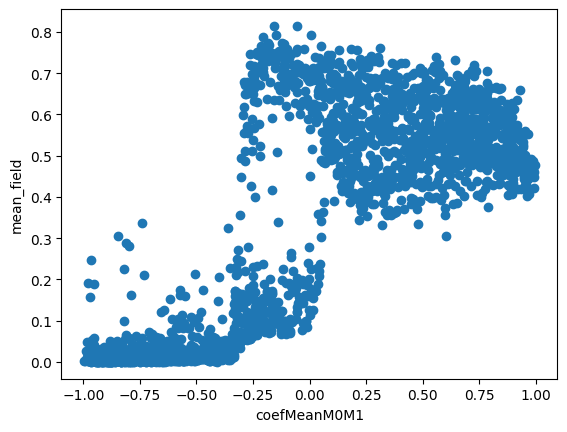

In [ ]:
# plot cross-plot

df=pd.read_csv(path_to_models+'5001007_spec.csv',sep=',')

plt.scatter(df['coefMeanM0M1'],df['mean_field'])
plt.xlabel('coefMeanM0M1')
plt.ylabel('mean_field')

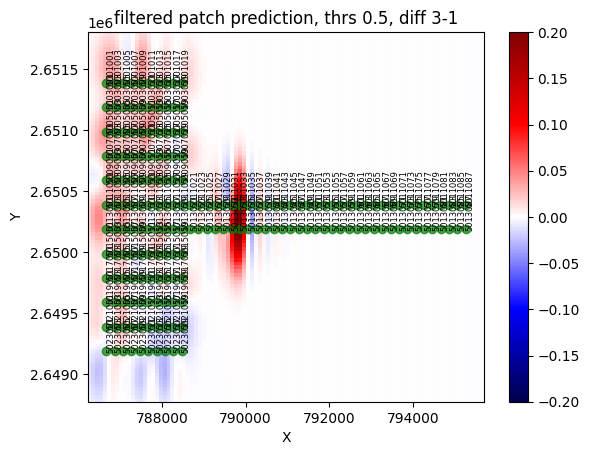

In [ ]:
# plot diff(3-1) field using part1.txt and part3.txt

with open(path_to_models_part1+f'/result_part1_thrs_{thrs}_{datetime}.txt','r') as f:
  dat1=f.readlines()
f.close()

with open(path_to_models_part3+f'/result_part3_thrs_{thrs}_{datetime}.txt','r') as f:
  dat3=f.readlines()
f.close()

pred1=np.zeros((len(pred_files_class),4))
for i,line in enumerate(dat1[1:]):
  pred1[i,:]=[float(j) for j in line.split(' ')]

pred3=np.zeros((len(pred_files_class),4))
for i,line in enumerate(dat3[1:]):
  pred3[i,:]=[float(j) for j in line.split(' ')]

x1=pred1[:,1]
y1=pred1[:,2]
z1=pred1[:,3]-0.5

x3=pred3[:,1]
y3=pred3[:,2]
z3=pred3[:,3]-0.5

vmin,vmax=-0.2,0.2

rbf_fun1 = Rbf(x1, y1, z1, function="gaussian")
rbf_fun3 = Rbf(x3, y3, z3, function="gaussian")

x_new = np.linspace(coords[:,1].min()-400, coords[:,1].max()+400, 100)
y_new = np.linspace(coords[:,2].min()-400, coords[:,2].max()+400, 100)

x_grid, y_grid = np.meshgrid(x_new, y_new)
z_new1 = rbf_fun1(x_grid.ravel(), y_grid.ravel()).reshape(x_grid.shape)
z_new3 = rbf_fun3(x_grid.ravel(), y_grid.ravel()).reshape(x_grid.shape)

plt.pcolor(x_grid, y_grid, z_new3-z_new1,vmin=vmin,vmax=vmax,cmap='seismic')
plt.colorbar(cmap='seismic')
plt.scatter(x1,y1,color='g',marker='o',alpha=0.7)
plt.xlabel('X')
plt.ylabel('Y')
plt.title(f'filtered patch prediction, thrs {thrs}, diff 3-1')

for i in range(coords.shape[0]):
    plt.annotate(str(int(coords[i,0])), (x1[i], y1[i] + 0.2),fontsize=6,rotation=90)

In [ ]:
# NOT USED NOW
# # plot fields (for each model from N models separately)
# for num_mod in range(num_models):

#   with open(path_to_models+f'result_thrs_{thrs}_{datetime}_{num_mod}.txt','r') as f:
#     dat=f.readlines()
#   f.close()

#   pred=np.zeros((len(pred_files_class),4))
#   for i,line in enumerate(dat[1:]):
#     pred[i,:]=[float(j) for j in line.split(' ')]

#   x=pred[:,1]
#   y=pred[:,2]
#   z=pred[:,3]-0.5

#   vmin,vmax=-0.2,0.2
#   rbf_fun = Rbf(x, y, z, function="gaussian")

#   x_new = np.linspace(coords[:,1].min()-400, coords[:,1].max()+400, 100)
#   y_new = np.linspace(coords[:,2].min()-400, coords[:,2].max()+400, 100)

#   x_grid, y_grid = np.meshgrid(x_new, y_new)
#   z_new = rbf_fun(x_grid.ravel(), y_grid.ravel()).reshape(x_grid.shape)

#   plt.pcolor(x_grid, y_grid, z_new,vmin=vmin,vmax=vmax,cmap='seismic')
#   plt.colorbar(cmap='seismic')
#   plt.scatter(x,y,color='g',marker='o',alpha=0.7)
#   plt.xlabel('X')
#   plt.ylabel('Y')
#   plt.title(f'mean result of {num_models} models, thrs {thrs}')

#   for i in range(pred.shape[0]):
#       plt.annotate(str(int(pred[i,0])), (x[i], y[i] + 0.2),fontsize=6,rotation=60)

#   plt.savefig(path_to_models+f'result_thrs_{thrs}_{datetime}_{num_mod}.png')
#   plt.close()

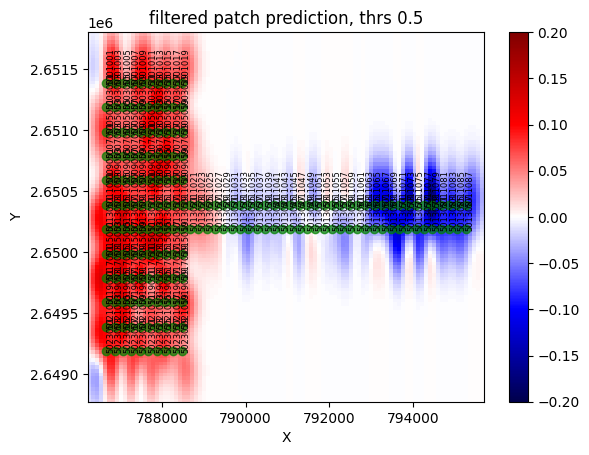

In [ ]:
#plot field using results.txt

with open(path_to_models+f'result_thrs_{thrs}_{datetime}.txt','r') as f:
    dat=f.readlines()
f.close()

pred=np.zeros((len(pred_files_class),4))
for i,line in enumerate(dat[1:]):
  pred[i,:]=[float(j) for j in line.split(' ')]

x=pred[:,1]
y=pred[:,2]
z=pred[:,3]-0.5

vmin,vmax=-0.2,0.2
rbf_fun = Rbf(x, y, z, function="gaussian")

x_new = np.linspace(coords[:,1].min()-400, coords[:,1].max()+400, 100)
y_new = np.linspace(coords[:,2].min()-400, coords[:,2].max()+400, 100)

x_grid, y_grid = np.meshgrid(x_new, y_new)
z_new = rbf_fun(x_grid.ravel(), y_grid.ravel()).reshape(x_grid.shape)

plt.pcolor(x_grid, y_grid, z_new,vmin=vmin,vmax=vmax,cmap='seismic')
plt.colorbar(cmap='seismic')
plt.scatter(x,y,color='g',marker='o',alpha=0.7)
plt.xlabel('X')
plt.ylabel('Y')
plt.title(f'filtered patch prediction, thrs {thrs}')

for i in range(pred.shape[0]):
    plt.annotate(str(int(pred[i,0])), (x[i], y[i] + 0.2),fontsize=6,rotation=90)

# plt.savefig(path_to_models+f'result_thrs_{thrs}_{datetime}_{num_mod}.png')
# plt.close()

In [ ]:
#!zip -r models.zip /content/models/

In [ ]:
# union results from different freqs ranges (method 1)
folders_fr_rng=os.listdir('/content/models')
thrs_qua=0
res=[]
for name in pred_files_class:

  df=pd.read_csv(f'/content/models/{folders_fr_rng[0]}/'+name,sep=',')

  new_coef_cs=np.zeros(df.shape[0])
  new_mean_field=np.zeros(df.shape[0])

  df_total=[]

  for folder in sorted(folders_fr_rng):
    df_total.append(pd.read_csv(f'/content/models/{folder}/'+name,sep=','))

  for i in range(df_total[0].shape[0]):
    new_coef_cs_num=0
    new_mean_field_num=0
    count=0
    for freq in range(len(df_total)):

      if df_total[freq].loc[i,'mean_field']>thrs_qua:
        new_coef_cs_num=new_coef_cs_num+df_total[freq].loc[i,'coefCs']*df_total[freq].loc[i,'mean_field']
        new_mean_field_num=new_mean_field_num+df_total[freq].loc[i,'mean_field']
        count+=1

    if count>0:
      new_coef_cs[i]=new_coef_cs_num/new_mean_field_num
      new_mean_field[i]=new_mean_field_num/count
    else:
      new_coef_cs[i]=0.5
      new_mean_field[i]=0

  res.append(np.mean(new_coef_cs[new_mean_field>thrs]))

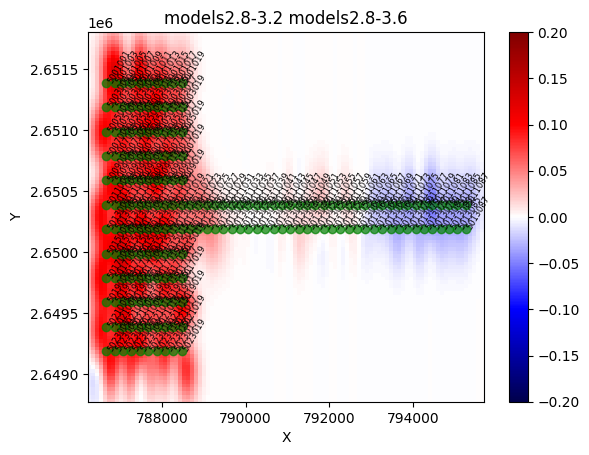

In [ ]:
res=np.array(res)

x=coords[:,1]
y=coords[:,2]
z=res-0.5

vmin,vmax=-0.2,0.2
rbf_fun = Rbf(x, y, z, function="gaussian")

x_new = np.linspace(coords[:,1].min()-400, coords[:,1].max()+400, 100)
y_new = np.linspace(coords[:,2].min()-400, coords[:,2].max()+400, 100)

x_grid, y_grid = np.meshgrid(x_new, y_new)
z_new = rbf_fun(x_grid.ravel(), y_grid.ravel()).reshape(x_grid.shape)

plt.pcolor(x_grid, y_grid, z_new,vmin=vmin,vmax=vmax,cmap='seismic')
plt.colorbar(cmap='seismic')
plt.scatter(x,y,color='g',marker='o',alpha=0.7)
plt.xlabel('X')
plt.ylabel('Y')
plt.title(' '.join(f for f in folders_fr_rng))

for i in range(pred.shape[0]):
    plt.annotate(str(int(pred[i,0])), (x[i], y[i] + 0.2),fontsize=6,rotation=60)

# plt.savefig(path_to_models+f'result_thrs_{thrs}_{datetime}_{num_mod}.png')
# plt.close()

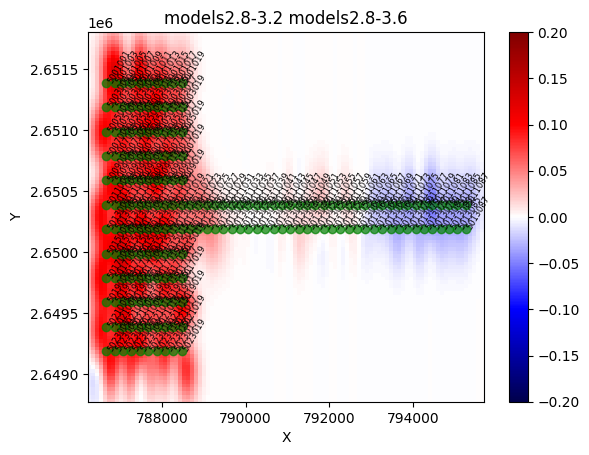

In [55]:
# union results using different freq range (method 2)
res=[]
for name in pred_files_class:

  #union_df=dict()
  sum_numerator_new_coef_cs=0
  sum_denominator_new_coef_cs=0
  for i,folder in enumerate(sorted(folders_fr_rng)):
    df=pd.read_csv(f'/content/models/{folder}/'+name,sep=',')
    #union_df.update({i:df})
    sum_numerator_new_coef_cs=sum_numerator_new_coef_cs+df['coefCs']*df['mean_field']
    sum_denominator_new_coef_cs=sum_denominator_new_coef_cs+df['mean_field']

  new_coef_cs=sum_numerator_new_coef_cs/sum_denominator_new_coef_cs
  new_mean_field=sum_denominator_new_coef_cs/len(folders_fr_rng)

  #df1=pd.read_csv('/content/models3.3-3.5/'+name,sep=',')
  #df=pd.read_csv('/content/models3.2-3.6/'+name,sep=',')

  #new_coef_cs=(df['coefCs']*df['mean_field']+df1['coefCs']*df1['mean_field'])/(df['mean_field']+df1['mean_field'])
  #new_mean_field=(df['mean_field']+df1['mean_field'])/2

  res.append(np.mean(new_coef_cs[new_mean_field>thrs]))


res=np.array(res)

x=coords[:,1]
y=coords[:,2]
z=res-0.5

vmin,vmax=-0.2,0.2
rbf_fun = Rbf(x, y, z, function="gaussian")

x_new = np.linspace(coords[:,1].min()-400, coords[:,1].max()+400, 100)
y_new = np.linspace(coords[:,2].min()-400, coords[:,2].max()+400, 100)

x_grid, y_grid = np.meshgrid(x_new, y_new)
z_new = rbf_fun(x_grid.ravel(), y_grid.ravel()).reshape(x_grid.shape)

plt.pcolor(x_grid, y_grid, z_new,vmin=vmin,vmax=vmax,cmap='seismic')
plt.colorbar(cmap='seismic')
plt.scatter(x,y,color='g',marker='o',alpha=0.7)
plt.xlabel('X')
plt.ylabel('Y')
plt.title(' '.join(f for f in folders_fr_rng))

for i in range(pred.shape[0]):
    plt.annotate(str(int(pred[i,0])), (x[i], y[i] + 0.2),fontsize=6,rotation=60)

# plt.savefig(path_to_models+f'result_thrs_{thrs}_{datetime}_{num_mod}.png')
# plt.close()